In [62]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [68]:
con = pg.connect(database="postgres", user="flatiron_user_1", password="K*%4t3VK0ab%gn", host="34.74.239.44", port="5432")
cur = con.cursor()
cur.execute(f"SELECT REVIEW_COUNT FROM BUSINESS WHERE restaurant IS true")
review_counts=cur.fetchall()
len(review_counts)

82404

In [110]:
u_cutoff=np.percentile(review_counts, 85)
l_cutoff=10  #np.percentile(review_counts, 20)
l_cutoff,u_cutoff

(10, 87.0)

In [111]:
cur.execute(f"SELECT REVIEW_COUNT FROM BUSINESS WHERE restaurant IS true AND REVIEW_COUNT < {u_cutoff} AND REVIEW_COUNT > {l_cutoff}")

In [112]:
review_counts2=cur.fetchall()

In [113]:
len(review_counts2)

37618

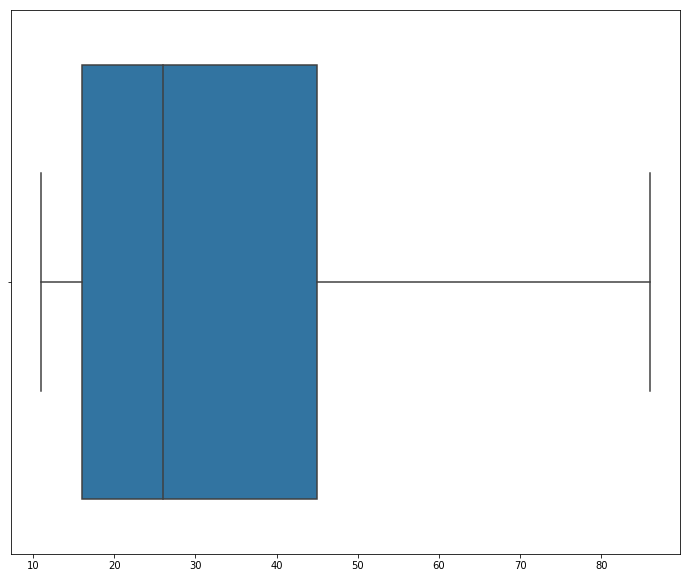

In [114]:
plt.figure(figsize=(12,10))
sns.boxplot(review_counts2);

In [45]:
con.close()

229.0

8348